In [2]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import Ackley
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [23]:
# unsure of how exactly to deal with the different cases
# for now I am just taking negative log transform of cases described
# ask about the way I've done the inequalities
# can implement c to be the running minimum also just by modifying properties in this class.
class Lm_ackley(Ackley):
    """Ackley function

    .. math::
        f(x_1,\\ldots,x_n) = -20\\exp\\left( -0.2 \\sqrt{\\frac{1}{n} \
        \\sum_{j=1}^n x_j^2} \\right) -\\exp \\left( \\frac{1}{n} \
        \\sum{j=1}^n \\cos(2 \\pi x_j) \\right) + 20 - e

    subject to

    .. math::
        -15 \\leq x_i \\leq 20

    Global optimum: :math:`f(0,0,...,0)=0`

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """

    def __init__(self, dim=10,ep = 1):
        self.ep = ep
        self.c = random.random()
        self.H_ys = []
        self.beta = 1/ep
        self.dim = dim
        self.min = 0
        self.minimum = np.zeros(dim)
        self.lb = -15 * np.ones(dim)
        self.ub = 20 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = str(dim) + "-dimensional Ackley function \n" + "Global optimum: f(0,0,...,0) = 0"

        # linear f
    def eval1(self, x):
        """Evaluate the modified ackley function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        if H_y <= self.c:
            self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified ackley function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        if H_y <= self.c:
            self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified ackley function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        if H_y <= self.c:
            self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )


In [5]:
class New_SerialController(SerialController):
    def __init__(self,objective, skip=False):
        "Initialize the controller."
        SerialController.__init__(self,objective, skip=False)
        self.x_values = []
        
    def new_feval(self, params, extra_args=None):
        """Add a function evaluation record to the database.
        In addition to adding the record with status 'pending',
        we run the feval_callbacks on the new record.
        Args:
            params: Parameters to the objective function
        Returns:
            New EvalRecord object
        """
        record = EvalRecord(params, extra_args=extra_args, status='pending')
        self.fevals.append(record)
        self.x_values.append(params)
        logger.debug("Call new feval callbacks")
        for callback in self.feval_callbacks:
            callback(record)
        return record
    

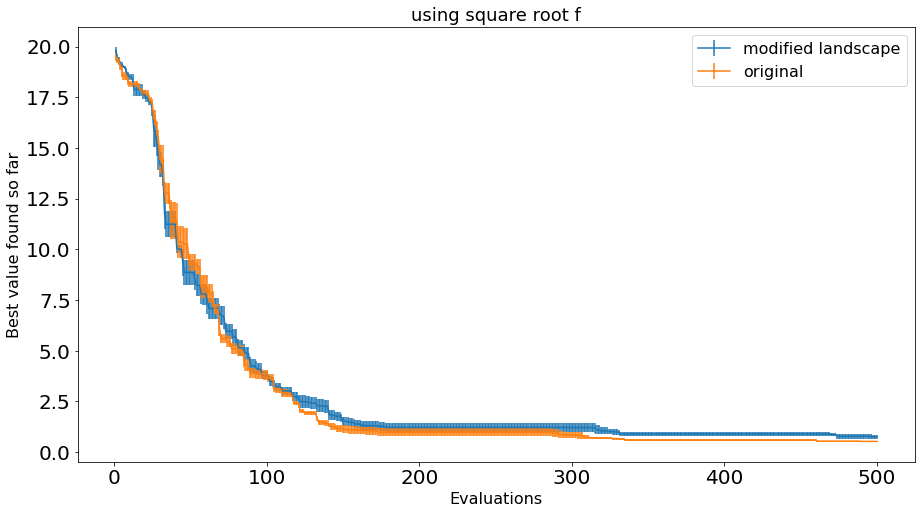

In [26]:
def plotter():
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    num_threads = 4
    max_evals = 500
    num_runs = 5
    lm_ackley = Lm_ackley(dim=10)
    rbf = RBFInterpolant(dim=lm_ackley.dim, lb=lm_ackley.lb, ub=lm_ackley.ub, kernel=CubicKernel(), tail=LinearTail(lm_ackley.dim))
    slhd = SymmetricLatinHypercube(dim=lm_ackley.dim, num_pts=2 * (lm_ackley.dim + 1))

    results_async1 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        # can change landscape by changing eval1 to eval2 or eval3 based on preferance
        controller1 = SerialController(objective=lm_ackley.eval3)
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller1.run()
        results_async1[:, i] = np.array(
            [H_y for H_y in lm_ackley.H_ys[i * max_evals:] if H_y is not None])
        
    results_async2 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        controller2 = SerialController(objective=lm_ackley.eval)
        controller2.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller2.run()
        results_async2[:, i] = np.array(
            [o.value for o in controller2.fevals if o.value is not None])

    plt.figure(figsize=(15, 8))
    for results in [results_async1, results_async2]:
        fvals = np.minimum.accumulate(results)
        plt.errorbar(np.arange(max_evals)+1, y=np.mean(fvals, axis=1), 
                     yerr=np.std(fvals, axis=1)/np.sqrt(float(num_runs)))

#     plt.plot(np.arange(0, fvals.shape[0]), np.minimum.accumulate(fvals), lw=2)
    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    plt.title('using square root f',fontsize = 18)
    plt.show()



random.seed(0)
np.random.seed(0)
plotter()

In [31]:
# when I do it serially and also not asynchronously I am able to make it deterministic
def example_simple(state):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    num_threads = 4
    max_evals = 500
    
    lm_ackley = Lm_ackley(dim=10)
    rbf = RBFInterpolant(dim=lm_ackley.dim, lb=lm_ackley.lb, ub=lm_ackley.ub, kernel=CubicKernel(), tail=LinearTail(lm_ackley.dim))
    slhd = SymmetricLatinHypercube(dim=lm_ackley.dim, num_pts=2 * (lm_ackley.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_ackley.eval1)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )


    # Run the optimization strategy
    result = controller.run()

    # Create a strategy and a controller
    controller1 = SerialController(objective=lm_ackley.eval)
    controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

    # Run the optimization strategy
    result1 = controller1.run()

    return lm_ackley.eval(result.params[0]),lm_ackley.eval(result1.params[0])
    


#example_simple(12)

In [37]:

def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times):
    lm = 0
    no_lm = 0
    for i in range(times):
        s = random.randint(0,1000)
        res = example_simple(i)
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    return lm,no_lm
    

In [ ]:
checker(100)